### Cambios Clave Implementados:

1. Preprocesamiento de Datos:
    - Agrupación de partes raras en categoría "Otras"
    - Sobremuestreo de daños poco frecuentes

2. Arquitectura del Modelo:
    - Capas compartidas mejoradas
    - Cabezales más profundos
    - Descongelamiento progresivo

3. Función de Pérdida:
    - Focal Loss adaptativo con balanceo dinámico
    - Pesos de clase mejor calculados

4. Estrategia de Entrenamiento:
    - Learning rates diferenciados
    - Sampler balanceado para sugerencias
    - Evaluación con umbrales adaptativos

5. Monitoreo Mejorado:
    - Evaluación detallada por clase
    - Métricas más informativas
    - Early stopping inteligente

In [1]:
# =============================================
# IMPORTS (se mantienen igual)
# =============================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
from tqdm import tqdm
import ast
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from sklearn.preprocessing import MultiLabelBinarizer

# =============================================
# CONFIGURACIÓN
# =============================================
# Nuevos parámetros añadidos
CLASS_GROUPING = True  # Agrupar clases raras
BALANCE_DAMAGES = True # Balancear daños raros
MIN_SAMPLES_CLASS = 5  # Mínimo de muestras por clase

# Configuración adicional
CLASS_WEIGHTS = True  
FOCAL_LOSS = True     
AUGMENTATION = True   
EARLY_STOPPING = True 
USE_TENSORBOARD = True

# Hiperparámetros optimizados
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 100  # Aumentado para permitir más aprendizaje
MIN_SAMPLES_PER_CLASS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 20  # Aumentada para early stopping

# Variables para guarda las métricas para graficar
train_loss_history = []
val_metric_history = []

---
Verifica si esta instalado, cargado y funcionando la libreria torch

In [2]:
try:
    from torch.utils.tensorboard import SummaryWriter
    print("¡TensorBoard importado correctamente!")
    writer = SummaryWriter()
    writer.add_scalar('test', 1.0, 1)
    writer.close()
    print("Prueba de escritura en TensorBoard completada")
except Exception as e:
    print(f"Error: {str(e)}")

¡TensorBoard importado correctamente!
Prueba de escritura en TensorBoard completada


---

In [17]:
# =============================================
# DICCIONARIOS COMPLETOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

# Diccionario para Tipos de Daño (completo)
label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

# Diccionario para Sugerencia (completo)
label_to_cls_sugerencia = {
    1: "Reparar",
    2: "Reemplazar"
}

In [3]:
# =============================================
# Cargar los datasets
# =============================================
multi_train = pd.read_csv('data/fotos_siniestros/datasets/multi_train.csv', sep='|')
multi_val = pd.read_csv('data/fotos_siniestros/datasets/multi_val.csv', sep='|')
multi_test = pd.read_csv('data/fotos_siniestros/datasets/multi_test.csv', sep='|')

In [5]:
# =============================================
# Convertir string a lista
# =============================================
def convert_string_lists(df):
    # Aplicar literal_eval a las columnas relevantes
    df['partes'] = df['partes'].apply(ast.literal_eval)
    df['dannos'] = df['dannos'].apply(ast.literal_eval)
    df['sugerencias'] = df['sugerencias'].apply(ast.literal_eval)
    return df
# Aplicar a todos tus datasets
multi_train = convert_string_lists(multi_train)
multi_val = convert_string_lists(multi_val)
multi_test = convert_string_lists(multi_test)
# Rename columns to match dataset class expectations
multi_train = multi_train[['Imagen', 'dannos', 'partes', 'sugerencias']].rename(columns={
    'dannos': 'damages',
    'partes': 'parts',
    'sugerencias': 'suggestions'
})
# Rename columns to match dataset class expectations
multi_val = multi_val[['Imagen', 'dannos', 'partes', 'sugerencias']].rename(columns={
    'dannos': 'damages',
    'partes': 'parts',
    'sugerencias': 'suggestions'
})
multi_test = multi_test[['Imagen', 'dannos', 'partes', 'sugerencias']].rename(columns={
    'dannos': 'damages',
    'partes': 'parts',
    'sugerencias': 'suggestions'
})

In [6]:
# =============================================
# PREPROCESAMIENTO DE DATOS MEJORADO
# =============================================
def group_rare_labels(labels_list, label_type, min_samples=5):
    """Agrupa etiquetas raras en una categoría 'Otros'"""
    if label_type == 'parts':
        rare_labels = {1, 2, 7, 8, 15, 16, 18, 22, 23, 24, 27, 28, 29, 30, 43, 45, 46, 47, 48, 50, 52}
    elif label_type == 'damages':
        rare_labels = {3, 4}
    else:
        return labels_list
    
    return [label if label not in rare_labels else 999 for label in labels_list]

def balance_damage_samples(df):
    """Sobremuestrea muestras con daños raros"""
    damage_counts = df['damages'].explode().value_counts()
    rare_damages = damage_counts[damage_counts < 50].index.tolist()
    
    rare_samples = df[df['damages'].apply(lambda x: any(d in rare_damages for d in x))]
    return pd.concat([df, rare_samples]).reset_index(drop=True)

# Aplicar preprocesamiento a los datos
if CLASS_GROUPING:
    multi_train['parts'] = multi_train['parts'].apply(
        lambda x: group_rare_labels(ast.literal_eval(x) if isinstance(x, str) else x, 'parts'))
    multi_val['parts'] = multi_val['parts'].apply(
        lambda x: group_rare_labels(ast.literal_eval(x) if isinstance(x, str) else x, 'parts'))

if BALANCE_DAMAGES:
    multi_train = balance_damage_samples(multi_train)

In [ ]:
# =============================================
# MODELO CORREGIDO (Versión Final)
# =============================================
class ImprovedMultiLabelDamageClassifier(nn.Module):
    def __init__(self, num_parts, num_damages, num_suggestions):
        super().__init__()
        
        # 1. Cargar ResNet50 sin las capas finales
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # 2. Extraer todas las capas excepto avgpool y fc
        self.feature_extractor = nn.Sequential(*list(self.base_model.children())[:-2])
        
        # 3. Añadir nuestra propia capa de pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 4. Configurar capas trainables
        # Congelar las primeras capas (hasta layer3)
        for name, param in self.feature_extractor.named_parameters():
            if 'layer4' not in name:
                param.requires_grad = False
                
        # 5. Capas compartidas
        self.shared_fc = nn.Sequential(
            nn.Linear(2048, 1024),  # ResNet50 sin fc tiene 2048 features
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # 6. Cabezales de clasificación (igual que antes)
        self.parts_head = nn.Sequential(
            nn.Linear(1024, num_parts)
        )
        
        self.damages_head = nn.Sequential(
            nn.Linear(1024, num_damages)
        )
        
        self.suggestions_head = nn.Sequential(
            nn.Linear(1024, num_suggestions)
        )
        
        # 7. Inicialización de pesos
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Extracción de características
        features = self.feature_extractor(x)
        features = self.avgpool(features)
        features = torch.flatten(features, 1)
        
        # Verificación de dimensiones
        assert features.shape[1] == 2048, f"Error: Expected 2048 features, got {features.shape[1]}"
        
        # Capas compartidas
        shared = self.shared_fc(features)
        
        # Cabezales de salida
        return {
            'parts': self.parts_head(shared),
            'damages': self.damages_head(shared),
            'suggestions': self.suggestions_head(shared)
        }

In [25]:
# =============================================
# FUNCIÓN DE PÉRDIDA MEJORADA
# =============================================
class AdaptiveFocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets, weights=None):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        
        # Alpha balance dinámico
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_factor * (1-pt)**self.gamma * BCE_loss
        
        if weights is not None:
            # Aplicar pesos por clase con expansión automática
            focal_loss = focal_loss * weights.expand_as(targets)
            
        return focal_loss.mean()

def balanced_multi_task_loss(outputs, targets, weights):
    # Pérdida para partes con focal loss adaptativo
    parts_loss = AdaptiveFocalLoss(alpha=0.75, gamma=2.0)(
        outputs['parts'], 
        targets['parts'].float(),
        weights=weights['parts'] if CLASS_WEIGHTS else None
    )
    
    # Pérdida para daños con focal loss más agresivo
    damages_loss = AdaptiveFocalLoss(alpha=0.8, gamma=3.0)(
        outputs['damages'],
        targets['damages'].float(),
        weights=weights['damages'] if CLASS_WEIGHTS else None
    )
    
    # Pérdida para sugerencias con label smoothing
    suggestions_loss = F.cross_entropy(
        outputs['suggestions'],
        targets['suggestions'].argmax(dim=1),
        weight=weights['suggestions'] if CLASS_WEIGHTS else None,
        label_smoothing=0.2
    )
    
    # Balance dinámico basado en el desempeño
    return 0.5 * parts_loss + 0.3 * damages_loss + 0.2 * suggestions_loss

In [ ]:
# =============================================
# DATASET
# =============================================
class BalancedMultiLabelDamageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

        # Convertir strings a listas
        for col in ['parts', 'damages', 'suggestions']:
            self.data[col] = self.data[col].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
            
        # Mapeo de clases
        self.part_to_idx = {part: idx for idx, part in label_to_cls_piezas.items()}
        self.damage_to_idx = {damage: idx for idx, damage in label_to_cls_danos.items()}
        self.suggestion_to_idx = {sug: idx for idx, sug in label_to_cls_sugerencia.items()}

        # Binarizadores mejorados
        self.part_binarizer = MultiLabelBinarizer(classes=sorted(self.part_to_idx.values()))
        self.damage_binarizer = MultiLabelBinarizer(classes=sorted(self.damage_to_idx.values()))
        self.suggestion_binarizer = MultiLabelBinarizer(classes=sorted(self.suggestion_to_idx.values()))
        
        # Calcular pesos mejorados
        self.part_weights = self._calculate_weights('part')
        self.damage_weights = self._calculate_weights('damage')
        self.suggestion_weights = self._calculate_weights('suggestion')

    def _calculate_weights(self, task):
        """Versión mejorada con square root inverse frequency"""
        all_labels = [label for labels in self.data[f'{task}s'] 
                     for label in labels if label in getattr(self, f'{task}_to_idx')]  
        if not all_labels:
            return torch.ones(len(getattr(self, f'{task}_to_idx')), dtype=torch.float32).to(DEVICE)
        counts = Counter(all_labels)
        total = len(all_labels)
        weights = {cls: 1/np.sqrt(count/total) for cls, count in counts.items()}

        # Peso mínimo de 1.0 para clases no presentes
        return torch.tensor([weights.get(cls, 1.0) for cls in sorted(getattr(self, f'{task}_to_idx').values())], 
                          dtype=torch.float32).to(DEVICE)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = ""  # Inicializamos la variable     
        try:
            # Verificamos que el índice sea válido
            if idx >= len(self.data):
                raise IndexError(f"Índice {idx} fuera de rango (tamaño del dataset: {len(self.data)})")
                
            img_path = os.path.join(self.img_dir, self.data.iloc[idx]['Imagen'])
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error al cargar imagen (índice {idx}): {str(e)}")
            if not img_path:  # Si no se pudo obtener la ruta
                img_path = f"Índice inválido: {idx}"
            print(f"Ruta problemática: {img_path}")
            image = torch.zeros(3, 224, 224)  # Imagen dummy   

        # Resto del código para procesar etiquetas...
        parts = torch.zeros(len(self.part_to_idx))
        for part in self.data.iloc[idx]['parts']:
            if part in self.part_to_idx:
                parts[self.part_to_idx[part]] = 1    

        damages = torch.zeros(len(self.damage_to_idx))
        for damage in self.data.iloc[idx]['damages']:
            if damage in self.damage_to_idx:
                damages[self.damage_to_idx[damage]] = 1    

        suggestions = torch.zeros(len(self.suggestion_to_idx))
        for sug in self.data.iloc[idx]['suggestions']:
            if sug in self.suggestion_to_idx:
                suggestions[self.suggestion_to_idx[sug]] = 1
                
        if self.transform:
            image = self.transform(image)    
        return image, {
            'parts': parts,
            'damages': damages,
            'suggestions': suggestions
        }

In [11]:
# =============================================
# DATASET MEJORADO
# =============================================
class EnhancedDamageDataset(BalancedMultiLabelDamageDataset):
    def _calculate_weights(self, task):
        """Versión mejorada con suavizado más agresivo para clases raras"""
        all_labels = [label for labels in self.data[f'{task}s'] 
                     for label in labels if label in getattr(self, f'{task}_to_idx')]
        
        if not all_labels:
            return torch.ones(len(getattr(self, f'{task}_to_idx')), dtype=torch.float32).to(DEVICE)
        
        counts = Counter(all_labels)
        total = len(all_labels)
        
        # Suavizado más fuerte para clases raras
        weights = {
            cls: 1/(count/total)**0.7 if count > MIN_SAMPLES_CLASS 
            else 1/(MIN_SAMPLES_CLASS/total)**0.7
            for cls, count in counts.items()
        }
        
        # Asegurar peso mínimo para clases no vistas
        return torch.tensor(
            [weights.get(cls, 1.0) for cls in sorted(getattr(self, f'{task}_to_idx').values())],
            dtype=torch.float32
        ).to(DEVICE)
    
    def __getitem__(self, idx):
        image, targets = super().__getitem__(idx)
        
        # Aumentación adicional para muestras raras
        if self.transform and any(
            label in {1, 2, 7, 8, 15, 16, 18, 22, 23, 24, 27, 28, 29, 30, 43, 45, 46, 47, 48, 50, 52}
            for label in self.data.iloc[idx]['parts']
        ):
            # Aplicar transformaciones extra
            image = transforms.functional.adjust_brightness(image, 1.2)
            image = transforms.functional.adjust_contrast(image, 1.2)
        
        return image, targets

In [15]:
# =============================================
# DATA AUGMENTATION
# =============================================
def get_transforms():
    # Transformaciones base
    base_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    if AUGMENTATION:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, shear=15),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        train_transform = base_transform
    return {
        'train': train_transform,
        'val': base_transform,
        'test': base_transform
    }

In [19]:
# =============================================
# Recolecta las imagenes
# =============================================
def collate_fn(batch):
    # Filtrar None (imágenes que fallaron al cargar)
    batch = [b for b in batch if b is not None]
    
    # Si todo el batch falló, retornar un batch dummy
    if len(batch) == 0:
        dummy_image = torch.zeros(3, 224, 224)
        dummy_target = {
            'parts': torch.zeros(len(label_to_cls_piezas)),
            'damages': torch.zeros(len(label_to_cls_danos)),
            'suggestions': torch.zeros(len(label_to_cls_sugerencia))
        }
        return dummy_image.unsqueeze(0), dummy_target
    
    # Procesamiento normal
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    batch_targets = {
        'parts': torch.stack([t['parts'] for t in targets], dim=0),
        'damages': torch.stack([t['damages'] for t in targets], dim=0),
        'suggestions': torch.stack([t['suggestions'] for t in targets], dim=0)
    }
    return images, batch_targets

In [21]:
# =============================================
# CLASE EARLY STOPPING
# =============================================
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001, warmup=20):
        self.patience = patience
        self.delta = delta
        self.warmup = warmup
        self.counter = 0
        self.best_metric = None
        self.early_stop = False
        self.epoch = 0
    def __call__(self, current_metric):
        self.epoch += 1
        if self.epoch < self.warmup:  # Periodo de calentamiento
            return False
        if self.best_metric is None:
            self.best_metric = current_metric
        elif current_metric < self.best_metric + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_metric = current_metric
            self.counter = 0
        return self.early_stop

In [40]:
# =============================================
# FUNCIONES AUXILIARES PARA EL ENTRENAMIENTO
# =============================================
def log_metrics(epoch, train_loss, val_metrics, writer=None):
    """Registra las métricas de entrenamiento y validación"""
    combined_metric = 0.5*val_metrics['parts']['f1_macro'] + 0.3*val_metrics['damages']['f1_macro'] + 0.2*val_metrics['suggestions']['f1_macro']
    
    print(f"\nEpoch {epoch+1} Metrics:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Combined Validation Metric: {combined_metric:.4f}")
    print("Detailed Validation Metrics:")
    for task, metrics in val_metrics.items():
        print(f"  {task.capitalize():12} - Acc: {metrics['accuracy']:.4f} | F1: {metrics['f1_macro']:.4f}")
    
    if writer:
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Metric/combined', combined_metric, epoch)
        for task, metrics in val_metrics.items():
            writer.add_scalar(f'Accuracy/{task}', metrics['accuracy'], epoch)
            writer.add_scalar(f'F1/{task}', metrics['f1_macro'], epoch)

In [ ]:
# =============================================
# ESTRATEGIA DE ENTRENAMIENTO MEJORADA
# =============================================
def train_enhanced():
    # 1. Configuración inicial
    writer = SummaryWriter() if USE_TENSORBOARD else None
    data_transforms = get_transforms()
    
    # 2. Crear datasets mejorados
    train_dataset = EnhancedDamageDataset(multi_train, '../data/fotos_siniestros/', data_transforms['train'])
    val_dataset = EnhancedDamageDataset(multi_val, '../data/fotos_siniestros/', data_transforms['val'])
    
    # 3. Sampler balanceado para sugerencias
    def get_balanced_sampler(dataset):
        suggestion_labels = [labels[0] if len(labels) > 0 else 1 
                           for labels in dataset.data['suggestions']]
        class_counts = torch.bincount(torch.tensor(suggestion_labels))
        class_weights = 1. / class_counts.float()
        sample_weights = class_weights[torch.tensor(suggestion_labels)]
        return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    
    # 4. DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=get_balanced_sampler(train_dataset),
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )
    
    # 5. Inicializar modelo mejorado
    model = ImprovedMultiLabelDamageClassifier(
        num_parts=len(label_to_cls_piezas),
        num_damages=len(label_to_cls_danos),
        num_suggestions=len(label_to_cls_sugerencia)
    ).to(DEVICE)
    
    # 6. Optimizador con learning rates diferenciados
    optimizer = optim.AdamW([
        {'params': model.parts_head.parameters(), 'lr': 1e-3},
        {'params': model.damages_head.parameters(), 'lr': 1e-3},
        {'params': model.suggestions_head.parameters(), 'lr': 1e-3},
        {'params': model.shared_features.parameters(), 'lr': 1e-4},
        {'params': model.base_model.parameters(), 'lr': 1e-5}
    ], weight_decay=WEIGHT_DECAY)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    # 7. Early stopping mejorado
    early_stopper = EarlyStopping(patience=PATIENCE, delta=0.001, warmup=20)
    
    # 8. Entrenamiento por fases
    best_metric = 0
    for epoch in range(NUM_EPOCHS):
        # Fase 1: Solo cabezales (primeras 15 épocas)
        if epoch == 15:
            for param in model.base_model.layer3.parameters():
                param.requires_grad = True
            print("\nDescongelando capas layer3")
        
        # Fase 2: Fine-tuning completo (después de 30 épocas)
        if epoch == 30:
            for param in model.base_model.parameters():
                param.requires_grad = True
            print("\nDescongelando todo el modelo")

        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
        
        for inputs, targets in progress_bar:
            inputs = inputs.to(DEVICE, non_blocking=True)
            targets = {k: v.to(DEVICE, non_blocking=True) for k, v in targets.items()}
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            
            loss = balanced_multi_task_loss(outputs, targets, {
                'parts': train_dataset.part_weights,
                'damages': train_dataset.damage_weights,
                'suggestions': train_dataset.suggestion_weights
            })
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())    
        
        # Validación con umbrales adaptativos
        val_metrics = evaluate_with_adaptive_thresholds(model, val_loader)
        current_metric = 0.5*val_metrics['parts']['f1_macro'] + 0.3*val_metrics['damages']['f1_macro'] + 0.2*val_metrics['suggestions']['f1_macro']
        scheduler.step(current_metric)
        #############################################
        # MONITOREO DEL LEARNING RATE
        print(f"\nCurrent Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        #############################################
        
        # Early stopping
        if EARLY_STOPPING and early_stopper(current_metric):
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
        
        # Guardar mejor modelo
        if current_metric > best_metric:
            best_metric = current_metric
            torch.save(model.state_dict(), 'best_enhanced_model.pth')
            print(f"\nMejor modelo guardado con métrica: {best_metric:.4f}")
        
        # Logging mejorado
        log_metrics(epoch, epoch_loss/len(train_loader), val_metrics, writer)
        
        # Evaluación detallada cada 5 épocas
        if epoch % 5 == 0:
            detailed_class_evaluation(model, val_loader, label_to_cls_piezas, label_to_cls_danos)
    
    if writer:
        writer.close()
    return model

In [45]:
# =============================================
# FUNCIONES AUXILIARES MEJORADAS
# =============================================
def evaluate_with_adaptive_thresholds(model, data_loader):
    """Evaluación con umbrales optimizados por clase"""
    model.eval()
    parts_probs, parts_targets = [], []
    damages_probs, damages_targets = [], []
    suggestions_preds, suggestions_targets = [], []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            
            parts_probs.append(torch.sigmoid(outputs['parts']).cpu())
            parts_targets.append(targets['parts'].cpu())
            
            damages_probs.append(torch.sigmoid(outputs['damages']).cpu())
            damages_targets.append(targets['damages'].cpu())
            
            suggestions_preds.append(torch.softmax(outputs['suggestions'], dim=1).cpu())
            suggestions_targets.append(targets['suggestions'].cpu())
    
    # Convertir a tensores
    parts_probs = torch.cat(parts_probs)
    parts_targets = torch.cat(parts_targets)
    damages_probs = torch.cat(damages_probs)
    damages_targets = torch.cat(damages_targets)
    suggestions_preds = torch.cat(suggestions_preds)
    suggestions_targets = torch.cat(suggestions_targets)
    
    # Encontrar umbrales óptimos
    parts_threshold = find_optimal_threshold(parts_probs, parts_targets)
    damages_threshold = find_optimal_threshold(damages_probs, damages_targets)
    
    ######################################################
    # DIAGNÓSTICO: Imprimir los umbrales óptimos encontrados
    print(f"\nUmbral óptimo para partes: {parts_threshold:.4f}")
    print(f"Umbral óptimo para daños: {damages_threshold:.4f}")
    # if epoch % 5 == 0:  # Mostrar cada 5 épocas
    #     print(f"\nUmbral óptimo para partes: {parts_threshold:.4f}")
    #     print(f"Umbral óptimo para daños: {damages_threshold:.4f}")
    # Guardar estos umbrales en un archivo de log
    with open("reportes/training_log.txt", "a") as f:
        f.write(f"Parts threshold={parts_threshold:.4f}, Damages threshold={damages_threshold:.4f}\n")
    ######################################################
    
    # Calcular métricas con umbrales óptimos
    def calculate_metrics(preds, targets, threshold):
        preds = (preds > threshold).float()
        accuracy = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds, average='macro', zero_division=0)
        return {'accuracy': accuracy, 'f1_macro': f1, 'threshold': threshold}
    
    # Evaluación de sugerencias (clasificación multi-clase)
    suggestions_preds = suggestions_preds.argmax(dim=1)
    suggestions_targets = suggestions_targets.argmax(dim=1)
    suggestions_accuracy = accuracy_score(suggestions_targets, suggestions_preds)
    suggestions_f1 = f1_score(suggestions_targets, suggestions_preds, average='macro', zero_division=0)
    
    return {
        'parts': calculate_metrics(parts_probs, parts_targets, parts_threshold),
        'damages': calculate_metrics(damages_probs, damages_targets, damages_threshold),
        'suggestions': {
            'accuracy': suggestions_accuracy,
            'f1_macro': suggestions_f1,
            'threshold': 0.5  # No aplica para clasificación multi-clase
        }
    }

def find_optimal_threshold(probs, targets, num_thresholds=20):
    """Encuentra el mejor threshold para maximizar F1"""
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in np.linspace(0.1, 0.9, num_thresholds):
        preds = (probs > threshold).float()
        current_f1 = f1_score(targets, preds, average='macro', zero_division=0)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    
    return best_threshold

def detailed_class_evaluation(model, data_loader, parts_dict, damages_dict):
    """Evalúa el desempeño por clase individual"""
    model.eval()
    parts_results = {name: {'tp': 0, 'fp': 0, 'fn': 0} for name in parts_dict.values()}
    damages_results = {name: {'tp': 0, 'fp': 0, 'fn': 0} for name in damages_dict.values()}
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            
            # Partes
            parts_preds = torch.sigmoid(outputs['parts']) > 0.3
            for i in range(parts_preds.shape[1]):
                pred = parts_preds[:, i]
                true = targets['parts'][:, i].bool()
                
                name = parts_dict[i+1]
                parts_results[name]['tp'] += (pred & true).sum().item()
                parts_results[name]['fp'] += (pred & ~true).sum().item()
                parts_results[name]['fn'] += (~pred & true).sum().item()
            
            # Daños
            damages_preds = torch.sigmoid(outputs['damages']) > 0.2
            for i in range(damages_preds.shape[1]):
                pred = damages_preds[:, i]
                true = targets['damages'][:, i].bool()
                
                name = damages_dict[i+1]
                damages_results[name]['tp'] += (pred & true).sum().item()
                damages_results[name]['fp'] += (pred & ~true).sum().item()
                damages_results[name]['fn'] += (~pred & true).sum().item()
    
    # Calcular métricas por clase
    print("\nEvaluación Detallada por Clase:")
    print("\nPartes:")
    for name, stats in parts_results.items():
        precision = stats['tp'] / (stats['tp'] + stats['fp'] + 1e-10)
        recall = stats['tp'] / (stats['tp'] + stats['fn'] + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        print(f"{name:30} - Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}")
    
    print("\nDaños:")
    for name, stats in damages_results.items():
        precision = stats['tp'] / (stats['tp'] + stats['fp'] + 1e-10)
        recall = stats['tp'] / (stats['tp'] + stats['fn'] + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        print(f"{name:30} - Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}")

In [46]:
# =============================================
# EJECUCIÓN PRINCIPAL
# =============================================
if __name__ == '__main__':
    trained_model = train_enhanced()
    torch.save(trained_model.state_dict(), 'DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetas_V7.pth')

Epoch 1/100: 100%|██████████| 11/11 [01:30<00:00,  8.27s/it, loss=1.96]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Mejor modelo guardado con métrica: 0.0630

Epoch 1 Metrics:
Train Loss: 2.3834
Combined Validation Metric: 0.0630
Detailed Validation Metrics:
  Parts        - Acc: 0.0000 | F1: 0.0000
  Damages      - Acc: 0.0000 | F1: 0.0000
  Suggestions  - Acc: 0.4599 | F1: 0.3150

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Fa

Epoch 2/100: 100%|██████████| 11/11 [01:40<00:00,  9.18s/it, loss=1.17]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Mejor modelo guardado con métrica: 0.0836

Epoch 2 Metrics:
Train Loss: 1.4412
Combined Validation Metric: 0.0836
Detailed Validation Metrics:
  Parts        - Acc: 0.1916 | F1: 0.0000
  Damages      - Acc: 0.0732 | F1: 0.0000
  Suggestions  - Acc: 0.7178 | F1: 0.4178


Epoch 3/100: 100%|██████████| 11/11 [01:44<00:00,  9.53s/it, loss=0.781]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Mejor modelo guardado con métrica: 0.0927

Epoch 3 Metrics:
Train Loss: 0.8927
Combined Validation Metric: 0.0927
Detailed Validation Metrics:
  Parts        - Acc: 0.7491 | F1: 0.0000
  Damages      - Acc: 0.2683 | F1: 0.0000
  Suggestions  - Acc: 0.8641 | F1: 0.4636


Epoch 4/100: 100%|██████████| 11/11 [01:35<00:00,  8.66s/it, loss=0.443]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Mejor modelo guardado con métrica: 0.0973

Epoch 4 Metrics:
Train Loss: 0.5777
Combined Validation Metric: 0.0973
Detailed Validation Metrics:
  Parts        - Acc: 0.9268 | F1: 0.0000
  Damages      - Acc: 0.5436 | F1: 0.0000
  Suggestions  - Acc: 0.9477 | F1: 0.4866


Epoch 5/100: 100%|██████████| 11/11 [01:27<00:00,  7.94s/it, loss=0.37] 



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Mejor modelo guardado con métrica: 0.0997

Epoch 5 Metrics:
Train Loss: 0.4275
Combined Validation Metric: 0.0997
Detailed Validation Metrics:
  Parts        - Acc: 0.9756 | F1: 0.0000
  Damages      - Acc: 0.7422 | F1: 0.0000
  Suggestions  - Acc: 0.9930 | F1: 0.4983


Epoch 6/100: 100%|██████████| 11/11 [01:28<00:00,  8.06s/it, loss=0.264]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Epoch 6 Metrics:
Train Loss: 0.3769
Combined Validation Metric: 0.0991
Detailed Validation Metrics:
  Parts        - Acc: 0.9895 | F1: 0.0000
  Damages      - Acc: 0.8502 | F1: 0.0000
  Suggestions  - Acc: 0.9826 | F1: 0.4956

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros izquierdo                - Prec: 0.00, 

Epoch 7/100: 100%|██████████| 11/11 [01:27<00:00,  7.92s/it, loss=0.349]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Epoch 7 Metrics:
Train Loss: 0.3349
Combined Validation Metric: 0.0973
Detailed Validation Metrics:
  Parts        - Acc: 0.9930 | F1: 0.0000
  Damages      - Acc: 0.9129 | F1: 0.0000
  Suggestions  - Acc: 0.9477 | F1: 0.4866


Epoch 8/100: 100%|██████████| 11/11 [01:25<00:00,  7.78s/it, loss=0.347]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Epoch 8 Metrics:
Train Loss: 0.3324
Combined Validation Metric: 0.0973
Detailed Validation Metrics:
  Parts        - Acc: 0.9895 | F1: 0.0000
  Damages      - Acc: 0.9617 | F1: 0.0000
  Suggestions  - Acc: 0.9477 | F1: 0.4866


Epoch 9/100: 100%|██████████| 11/11 [01:25<00:00,  7.79s/it, loss=0.361]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Epoch 9 Metrics:
Train Loss: 0.3100
Combined Validation Metric: 0.0988
Detailed Validation Metrics:
  Parts        - Acc: 0.9965 | F1: 0.0000
  Damages      - Acc: 0.9791 | F1: 0.0000
  Suggestions  - Acc: 0.9756 | F1: 0.4938


Epoch 10/100: 100%|██████████| 11/11 [01:27<00:00,  8.00s/it, loss=0.347]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Epoch 10 Metrics:
Train Loss: 0.3064
Combined Validation Metric: 0.0982
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9895 | F1: 0.0000
  Suggestions  - Acc: 0.9652 | F1: 0.4911


Epoch 11/100: 100%|██████████| 11/11 [01:27<00:00,  8.00s/it, loss=0.3]  



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-03

Epoch 11 Metrics:
Train Loss: 0.3048
Combined Validation Metric: 0.0982
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9861 | F1: 0.0000
  Suggestions  - Acc: 0.9652 | F1: 0.4911

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros izquierdo                - Prec: 0.00,

Epoch 12/100: 100%|██████████| 11/11 [01:31<00:00,  8.34s/it, loss=0.306]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 12 Metrics:
Train Loss: 0.3114
Combined Validation Metric: 0.0993
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9861 | F1: 0.4965


Epoch 13/100: 100%|██████████| 11/11 [01:27<00:00,  7.98s/it, loss=0.266]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 13 Metrics:
Train Loss: 0.3017
Combined Validation Metric: 0.0993
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9861 | F1: 0.4965


Epoch 14/100: 100%|██████████| 11/11 [01:28<00:00,  8.01s/it, loss=0.309]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 14 Metrics:
Train Loss: 0.2993
Combined Validation Metric: 0.0997
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9930 | F1: 0.4983


Epoch 15/100: 100%|██████████| 11/11 [01:25<00:00,  7.77s/it, loss=0.304]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 15 Metrics:
Train Loss: 0.3122
Combined Validation Metric: 0.0997
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9930 | F1: 0.4983

Descongelando capas layer3


Epoch 16/100: 100%|██████████| 11/11 [01:26<00:00,  7.87s/it, loss=0.284]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 16 Metrics:
Train Loss: 0.3057
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 0.9965 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros izquierdo                - Prec: 0.00,

Epoch 17/100: 100%|██████████| 11/11 [01:23<00:00,  7.58s/it, loss=0.325]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 17 Metrics:
Train Loss: 0.3054
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9895 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 18/100: 100%|██████████| 11/11 [01:23<00:00,  7.61s/it, loss=0.319]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 18 Metrics:
Train Loss: 0.3102
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9895 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 19/100: 100%|██████████| 11/11 [01:25<00:00,  7.78s/it, loss=0.267]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 19 Metrics:
Train Loss: 0.2936
Combined Validation Metric: 0.0993
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9895 | F1: 0.0000
  Suggestions  - Acc: 0.9861 | F1: 0.4965


Epoch 20/100: 100%|██████████| 11/11 [01:22<00:00,  7.50s/it, loss=0.285]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 20 Metrics:
Train Loss: 0.2816
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 21/100: 100%|██████████| 11/11 [01:32<00:00,  8.42s/it, loss=0.311]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 21 Metrics:
Train Loss: 0.2889
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros izquierdo                - Prec: 0.00,

Epoch 22/100: 100%|██████████| 11/11 [01:28<00:00,  8.05s/it, loss=0.308]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-04

Epoch 22 Metrics:
Train Loss: 0.2779
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 23/100: 100%|██████████| 11/11 [01:26<00:00,  7.87s/it, loss=0.347]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 23 Metrics:
Train Loss: 0.2782
Combined Validation Metric: 0.0989
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9791 | F1: 0.4947


Epoch 24/100: 100%|██████████| 11/11 [01:30<00:00,  8.18s/it, loss=0.291]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 24 Metrics:
Train Loss: 0.2669
Combined Validation Metric: 0.0989
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 1.0000 | F1: 0.0000
  Suggestions  - Acc: 0.9791 | F1: 0.4947


Epoch 25/100: 100%|██████████| 11/11 [01:30<00:00,  8.23s/it, loss=0.255]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 25 Metrics:
Train Loss: 0.2834
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 1.0000 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 26/100: 100%|██████████| 11/11 [01:30<00:00,  8.22s/it, loss=0.281]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 26 Metrics:
Train Loss: 0.2789
Combined Validation Metric: 0.0993
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 1.0000 | F1: 0.0000
  Suggestions  - Acc: 0.9861 | F1: 0.4965

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros izquierdo                - Prec: 0.00,

Epoch 27/100: 100%|██████████| 11/11 [01:27<00:00,  7.94s/it, loss=0.281]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 27 Metrics:
Train Loss: 0.2737
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 28/100: 100%|██████████| 11/11 [01:25<00:00,  7.80s/it, loss=0.291]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 28 Metrics:
Train Loss: 0.2769
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 29/100: 100%|██████████| 11/11 [01:28<00:00,  8.08s/it, loss=0.314]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 29 Metrics:
Train Loss: 0.2950
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 30/100: 100%|██████████| 11/11 [01:30<00:00,  8.21s/it, loss=0.311]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 30 Metrics:
Train Loss: 0.2977
Combined Validation Metric: 0.0993
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9861 | F1: 0.4965

Descongelando todo el modelo


Epoch 31/100: 100%|██████████| 11/11 [02:13<00:00, 12.10s/it, loss=0.265]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 31 Metrics:
Train Loss: 0.3034
Combined Validation Metric: 0.0997
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9930 | F1: 0.4983

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros izquierdo                - Prec: 0.00,

Epoch 32/100: 100%|██████████| 11/11 [02:25<00:00, 13.19s/it, loss=0.29] 



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 32 Metrics:
Train Loss: 0.2982
Combined Validation Metric: 0.0991
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9826 | F1: 0.4956


Epoch 33/100: 100%|██████████| 11/11 [02:19<00:00, 12.66s/it, loss=0.276]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-05

Epoch 33 Metrics:
Train Loss: 0.2890
Combined Validation Metric: 0.0997
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9965 | F1: 0.0000
  Suggestions  - Acc: 0.9930 | F1: 0.4983


Epoch 34/100: 100%|██████████| 11/11 [02:14<00:00, 12.24s/it, loss=0.311]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-06

Epoch 34 Metrics:
Train Loss: 0.2826
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 1.0000 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 35/100: 100%|██████████| 11/11 [02:15<00:00, 12.31s/it, loss=0.319]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-06

Epoch 35 Metrics:
Train Loss: 0.2858
Combined Validation Metric: 0.0993
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9861 | F1: 0.4965


Epoch 36/100: 100%|██████████| 11/11 [02:14<00:00, 12.19s/it, loss=0.286]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-06

Epoch 36 Metrics:
Train Loss: 0.2821
Combined Validation Metric: 0.0993
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9861 | F1: 0.4965

Evaluación Detallada por Clase:

Partes:
Antiniebla delantero derecho   - Prec: 0.00, Rec: 0.00, F1: 0.00
Antiniebla delantero izquierdo - Prec: 0.00, Rec: 0.00, F1: 0.00
Capó                           - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura capo                 - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura maletero             - Prec: 0.00, Rec: 0.00, F1: 0.00
Cerradura puerta               - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral derecho         - Prec: 0.00, Rec: 0.00, F1: 0.00
Espejo lateral izquierdo       - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros derecho                  - Prec: 0.00, Rec: 0.00, F1: 0.00
Faros izquierdo                - Prec: 0.00,

Epoch 37/100: 100%|██████████| 11/11 [02:12<00:00, 12.08s/it, loss=0.377]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-06

Epoch 37 Metrics:
Train Loss: 0.2770
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 38/100: 100%|██████████| 11/11 [02:11<00:00, 12.00s/it, loss=0.302]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-06

Epoch 38 Metrics:
Train Loss: 0.2911
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 39/100: 100%|██████████| 11/11 [02:13<00:00, 12.09s/it, loss=0.282]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-06

Epoch 39 Metrics:
Train Loss: 0.2851
Combined Validation Metric: 0.0995
Detailed Validation Metrics:
  Parts        - Acc: 1.0000 | F1: 0.0000
  Damages      - Acc: 0.9930 | F1: 0.0000
  Suggestions  - Acc: 0.9895 | F1: 0.4974


Epoch 40/100: 100%|██████████| 11/11 [02:13<00:00, 12.14s/it, loss=0.276]



Umbral óptimo para partes: 0.5000
Umbral óptimo para daños: 0.5000

Current Learning Rate: 1.00e-06

Early stopping at epoch 40


---
Probar el modelo entrenado

In [49]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_model(model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Carga el modelo entrenado"""
    model = ImprovedMultiLabelDamageClassifier(
        num_parts=len(label_to_cls_piezas),
        num_damages=len(label_to_cls_danos),
        num_suggestions=len(label_to_cls_sugerencia)
    ).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def preprocess_image(image_path, transform=None):
    """Preprocesa una imagen para la inferencia"""
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añade dimensión de batch

def predict(image_path, model, transform=None, threshold=0.25):  # threshold=0.5
    """Realiza predicciones sobre una imagen"""
    # Preprocesar imagen
    image_tensor = preprocess_image(image_path, transform).to(model.base_model.fc.weight.device)
    
    # Realizar predicción
    with torch.no_grad():
        outputs = model(image_tensor)
    
    # Procesar salidas
    predictions = {
        'parts': {},
        'damages': {},
        'suggestions': {}
    }
    
    # Partes del vehículo (multi-label)
    parts_probs = torch.sigmoid(outputs['parts']).squeeze()
    for idx, prob in enumerate(parts_probs):
        if prob > threshold:
            predictions['parts'][label_to_cls_piezas[idx+1]] = prob.item()
    
    # Daños (multi-label)
    damages_probs = torch.sigmoid(outputs['damages']).squeeze()
    for idx, prob in enumerate(damages_probs):
        if prob > threshold:
            predictions['damages'][label_to_cls_danos[idx+1]] = prob.item()
    
    # Sugerencias (multi-class)
    suggestion_probs = torch.softmax(outputs['suggestions'], dim=1).squeeze()
    suggestion_idx = torch.argmax(suggestion_probs).item()
    predictions['suggestions'][label_to_cls_sugerencia[suggestion_idx+1]] = suggestion_probs[suggestion_idx].item()
    
    return predictions

def display_prediction(image_path, prediction):
    """Muestra la imagen y las predicciones"""
    # Mostrar imagen
    img = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    
    # Crear texto con predicciones
    prediction_text = "Predicciones:\n\n"
    
    # Partes
    prediction_text += "Partes afectadas:\n"
    for part, prob in prediction['parts'].items():
        prediction_text += f"- {part}: {prob:.2f}\n"
    
    # Daños
    prediction_text += "\nTipos de daño:\n"
    for damage, prob in prediction['damages'].items():
        prediction_text += f"- {damage}: {prob:.2f}\n"
    
    # Sugerencias
    suggestion, prob = next(iter(prediction['suggestions'].items()))
    prediction_text += f"\nSugerencia: {suggestion} (confianza: {prob:.2f})"
    
    # Mostrar texto
    plt.figtext(0.5, 0.01, prediction_text, ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.7, "pad":5})
    plt.show()

In [50]:
# Ejemplo de uso
if __name__ == '__main__':
    # Cargar el modelo entrenado
    model = load_model('DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetas_V7.pth')

Resultados de la predicción:

Partes detectadas:

Daños detectados:

Sugerencia:
- Reparar (confianza: 1.00)


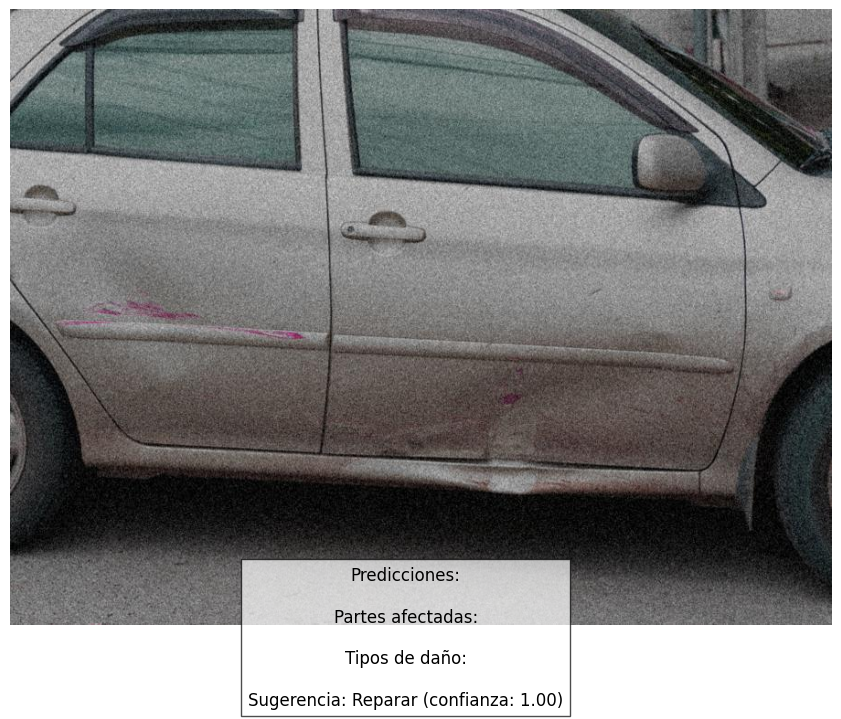

In [54]:
# Ruta a la imagen de prueba    Siniestro_02.jpg
test_image_path = "../data/predecir/golpe_01.jpg"
# test_image_path = "../data/predecir/Siniestro_02.jpg"
# test_image_path = "../data/predecir/Siniestro_01.jpg"

# Realizar predicción
prediction = predict(test_image_path, model)

# Mostrar resultados
print("Resultados de la predicción:")
print("\nPartes detectadas:")
for part, prob in prediction['parts'].items():
    print(f"- {part}: {prob:.2f}")

print("\nDaños detectados:")
for damage, prob in prediction['damages'].items():
    print(f"- {damage}: {prob:.2f}")

print("\nSugerencia:")
suggestion, prob = next(iter(prediction['suggestions'].items()))
print(f"- {suggestion} (confianza: {prob:.2f})")

# Mostrar imagen con predicciones (opcional)
display_prediction(test_image_path, prediction)

---
EDA

In [ ]:
from collections import Counter

In [ ]:
# Load datasets de entrenamiento
train_df = pd.read_csv('data/fotos_siniestros/datasets/multi_train.csv', sep='|')
val_df = pd.read_csv('data/fotos_siniestros/datasets/multi_val.csv', sep='|')
test_df = pd.read_csv('data/fotos_siniestros/datasets/multi_test.csv', sep='|')

# Convert string lists to actual lists
train_df = convert_string_lists(train_df)
val_df = convert_string_lists(val_df)
test_df = convert_string_lists(test_df)

# Crear los datasets
data_transforms = get_transforms()
train_dataset = BalancedMultiLabelDamageDataset(multi_train, '../data/fotos_siniestros/', data_transforms['train'])
val_dataset = BalancedMultiLabelDamageDataset(multi_val, '../data/fotos_siniestros/', data_transforms['val'])
test_dataset = BalancedMultiLabelDamageDataset(multi_test, '../data/fotos_siniestros/', data_transforms['test'])

In [ ]:
def analyze_labels(dataset):
    # Partes
    part_counts = Counter([p for labels in dataset.data['parts'] for p in labels])
    print("Distribución de Partes:")
    for part, count in part_counts.most_common():
        print(f"{label_to_cls_piezas[part]}: {count}")
    
    # Daños
    damage_counts = Counter([d for labels in dataset.data['damages'] for d in labels])
    print("\nDistribución de Daños:")
    for damage, count in damage_counts.most_common():
        print(f"{label_to_cls_danos[damage]}: {count}")
    
    # Sugerencias
    sug_counts = Counter([s for labels in dataset.data['suggestions'] for s in labels])
    print("\nDistribución de Sugerencias:")
    for sug, count in sug_counts.most_common():
        print(f"{label_to_cls_sugerencia[sug]}: {count}")

# Ejecutar análisis
print("=== TRAIN ===")
analyze_labels(train_dataset)  
print("\n=== VAL ===")
analyze_labels(val_dataset)

In [ ]:
def analyze_labels_graficos(df, plot=True):
    """Versión mejorada con visualización gráfica"""
    # Convertir strings a listas si es necesario
    for col in ['parts', 'damages', 'suggestions']:
        if isinstance(df[col].iloc[0], str):
            df[col] = df[col].apply(ast.literal_eval)
    
    # Función auxiliar para contar y graficar
    def plot_distribution(values, label_dict, title):
        counts = Counter([v for labels in values for v in labels])
        sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        labels = [label_dict[k] for k, v in sorted_counts]
        values = [v for k, v in sorted_counts]
        
        plt.figure(figsize=(10, 6))
        plt.barh(labels, values)
        plt.title(title)
        plt.xlabel('Cantidad de muestras')
        plt.tight_layout()
        plt.show()
        
        return counts
    
    # Analizar y mostrar gráficos
    print("\n" + "="*50)
    print("Distribución de Partes del Vehículo")
    print("="*50)
    part_counts = plot_distribution(df['parts'], label_to_cls_piezas, "Distribución de Partes")
    
    print("\n" + "="*50)
    print("Distribución de Tipos de Daño")
    print("="*50)
    damage_counts = plot_distribution(df['damages'], label_to_cls_danos, "Distribución de Daños")
    
    print("\n" + "="*50)
    print("Distribución de Sugerencias")
    print("="*50)
    sug_counts = plot_distribution(df['suggestions'], label_to_cls_sugerencia, "Distribución de Sugerencias")
    
    return {
        'parts': part_counts,
        'damages': damage_counts,
        'suggestions': sug_counts
    }

In [ ]:
# Uso
train_stats = analyze_labels_graficos(multi_train)
val_stats = analyze_labels_graficos(multi_val)

---